In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime as dt
%matplotlib inline
import os
import sys
from tqdm import tqdm
sys.path.append('/home/basil/Desktop/cape_mend_SM_LCS/datatools')
import datatools as tools
import cmocean as cm
from scipy.interpolate import griddata


In [2]:
to_hd = '/media/basil/Elements/data/'
data_files, data_filepath = tools.get_data_paths_from_binary(to_hd,'Fram',file_end='nc')


In [3]:
data = xr.open_mfdataset(data_filepath[-1])

In [4]:
data_test = data.isel(TIME=0,STATION=0)

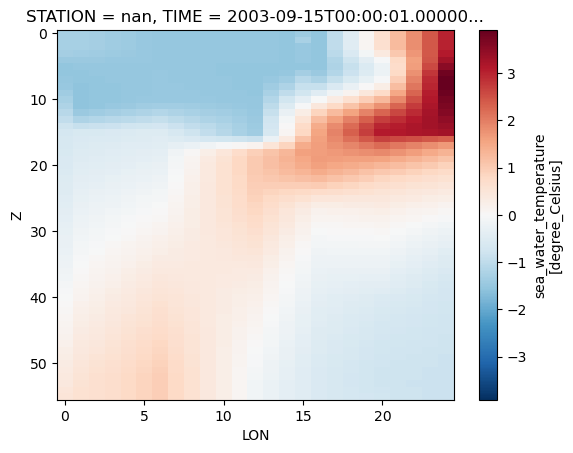

In [5]:
data_test['TEMP'].plot(y='Z')
plt.gca().invert_yaxis()

In [6]:
lat_sampled = data_test['LATITUDE']
lon_sampled = data_test['LONGITUDE']

In [7]:
grid = xr.open_dataset(to_hd+'llc270/llc270_grid_test.nc')
llc270_data = '/media/basil/Elements/data/llc270/'
model_salt_files, model_salt_filepath = tools.get_data_paths_from_binary(llc270_data,'SALT',file_end='nc')
model_salt = xr.open_mfdataset(model_salt_filepath)
model_temp_files, model_temp_filepath = tools.get_data_paths_from_binary(llc270_data,'THETA',file_end='nc')
model_temp = xr.open_mfdataset(model_temp_filepath)

In [8]:
salt = model_salt['SALT'].isel(tile=6)#.rename({'j':'i','i':'j'})

#salt.plot()
temp = model_temp['THETA'].isel(tile=6)
model_gridded = xr.merge([temp,salt,grid.isel(tile=6)])#.rename({'XC':'YC','YC':'XC'})])

In [9]:
model_gridded['XC'] = model_gridded['XC']*-1+104


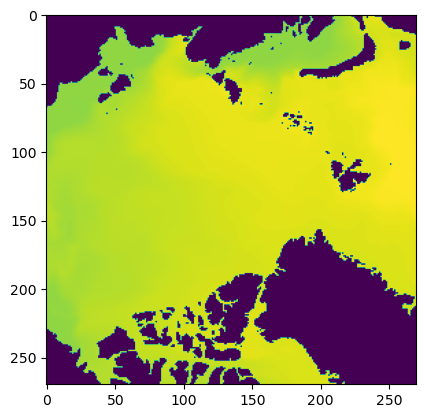

In [12]:
plt.imshow(np.rot90(salt.isel(time=0,k=0)).T)

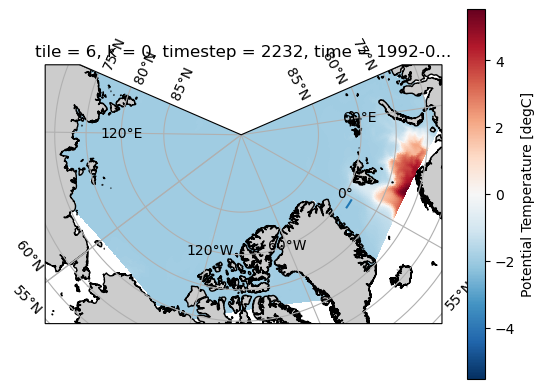

In [13]:
model_gridded = model_gridded.set_coords({'XC','YC'})
proj = ccrs.LambertConformal()

ax = plt.axes(projection=proj)
coast_10m = cfeature.NaturalEarthFeature("physical", "land", "10m", edgecolor="k", facecolor="0.8")

ax.add_feature(coast_10m)
gl = ax.gridlines(draw_labels=True)
model_gridded['THETA'].isel(time=0,k=0).plot(x='XC',y='YC',transform=ccrs.PlateCarree())

plt.plot(lon_sampled,lat_sampled,transform=ccrs.PlateCarree())

In [49]:
model_gridded['XC']
#transect_lon

<xarray.DataArray 'XC' (i: 270, j: 270)>
array([[ 52.      ,  51.924477,  51.825203, ..., -37.825195, -37.92447 ,
        -38.      ],
       [ 52.075523,  52.      ,  51.904606, ..., -37.904602, -38.      ,
        -38.07553 ],
       [ 52.174797,  52.095394,  52.      , ..., -38.      , -38.095398,
        -38.174805],
       ...,
       [141.8252  , 141.9046  , 142.      , ..., 232.      , 232.0954  ,
        232.1748  ],
       [141.92447 , 142.      , 142.0954  , ..., 231.9046  , 232.      ,
        232.07553 ],
       [142.      , 142.07553 , 142.1748  , ..., 231.8252  , 231.92447 ,
        232.      ]], dtype=float32)
Coordinates:
    tile     int64 6
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
    XC       (i, j) float32 52.0 51.92 51.83 51.71 ... 231.7 231.8 231.9 232.0
    YC       (i, j) float32 ...

In [15]:
grid_depth = xr.open_dataset('/media/basil/Elements/data/llc270/Grid/GRID.0007.nc')

grid_depth = grid_depth.rename({'i2':'j','i3':'i','i1':'k'})
grid_depth['i'] = (grid_depth['i']-1).astype(int)
grid_depth['j'] = (grid_depth['j']-1).astype(int)
grid_depth['k'] = (grid_depth['k'] -1).astype(int)
RC = np.array(grid_depth['RC'])

In [16]:
transect_lon = np.array(lon_sampled)
transect_lat = np.array(lat_sampled)
lat_cut = model_gridded.where(np.logical_and(transect_lat.max()+.5>model_gridded.YC,transect_lat.min()-.5<model_gridded.YC))
lon_cut = lat_cut.where(np.logical_and(transect_lon.max()+.5>lat_cut.XC,transect_lon.min()-.5<lat_cut.XC))
tran_cut = lon_cut.dropna(how='all',dim='i').dropna(how='all',dim='j').dropna(how='all',dim='time')


In [17]:
tran_cut = tran_cut.set_coords({'XC','YC'})

In [18]:
lon = tran_cut.XC
lat = tran_cut.YC
Lon, Lat = lon,lat
points = np.column_stack([np.ravel(Lon), np.ravel(Lat)])
# points_nan = points[~np.isnan(points)]
# points_nonan = np.reshape(points[~np.isnan(points)],(int(len(points_nan)/2),2))
# lon = points_nonan[:,0]
# lat = points_nonan[:,1]
# tran_cut.set_coords({'XC','YC'}).sel(XC=lon,YC=lat,method='nearest')
tran_cut.set_coords({'XC','YC'})

<xarray.Dataset>
Dimensions:   (time: 312, k: 50, j: 12, i: 9)
Coordinates:
    tile      int64 6
  * j         (j) int64 148 149 150 151 152 153 154 155 156 157 158 159
  * i         (i) int64 45 46 47 48 49 50 51 52 53
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    timestep  (time) int64 dask.array<chunksize=(12,), meta=np.ndarray>
  * time      (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16T12:00:00
    XC        (i, j) float32 -1.352 -1.962 -2.571 -3.177 ... -8.1 -8.742 -9.38
    YC        (i, j) float32 78.45 78.43 78.41 78.39 ... 79.33 79.3 79.27 79.24
Data variables:
    THETA     (time, k, j, i) float32 dask.array<chunksize=(12, 50, 12, 9), meta=np.ndarray>
    SALT      (time, k, j, i) float32 dask.array<chunksize=(12, 50, 12, 9), meta=np.ndarray>
    DXC       (i, j) float32 nan 1.374e+04 1.374e+04 nan ... 1.373e+04 nan nan
    DXG       (i, j) float32 nan 1.374e+04 1.374e+04 nan ... 1.373e+04 nan nan
    DYC       (i, j) float32 nan 1.529e+04 1.529e+04 nan ... 1.498e+04 nan nan
    DYG       (i, j) float32 nan 1.528e+04 1.528e+04 nan ... 1.497e+04 nan nan
    Depth     (i, j) float32 nan 121.3 40.0 nan ... 2.174e+03 2.363e+03 nan nan
    RAC       (i, j) float32 nan 2.099e+08 2.099e+08 nan ... 2.055e+08 nan nan
    RAZ       (i, j) float32 nan 2.102e+08 2.102e+08 nan ... 2.058e+08 nan nan
    XG        (i, j) float32 nan 105.6 106.2 nan nan ... 111.0 111.7 nan nan
    YG        (i, j) float32 nan 78.37 78.35 nan nan ... 79.28 79.25 nan nan
    hFacC     (k, i, j) float64 nan 1.0 1.0 nan nan nan ... 0.0 0.0 0.0 nan nan
Attributes:
    standard_name:  THETA
    long_name:      Potential Temperature
    units:          degC

In [19]:
tran_cut = tran_cut.sel(time=slice('2003-09','2017-12')).set_coords({'XC','YC'})
tran_cut

<xarray.Dataset>
Dimensions:   (time: 172, k: 50, j: 12, i: 9)
Coordinates:
    tile      int64 6
  * j         (j) int64 148 149 150 151 152 153 154 155 156 157 158 159
  * i         (i) int64 45 46 47 48 49 50 51 52 53
  * k         (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    timestep  (time) int64 dask.array<chunksize=(4,), meta=np.ndarray>
  * time      (time) datetime64[ns] 2003-09-16 ... 2017-12-16T12:00:00
    XC        (i, j) float32 -1.352 -1.962 -2.571 -3.177 ... -8.1 -8.742 -9.38
    YC        (i, j) float32 78.45 78.43 78.41 78.39 ... 79.33 79.3 79.27 79.24
Data variables:
    THETA     (time, k, j, i) float32 dask.array<chunksize=(4, 50, 12, 9), meta=np.ndarray>
    SALT      (time, k, j, i) float32 dask.array<chunksize=(4, 50, 12, 9), meta=np.ndarray>
    DXC       (i, j) float32 nan 1.374e+04 1.374e+04 nan ... 1.373e+04 nan nan
    DXG       (i, j) float32 nan 1.374e+04 1.374e+04 nan ... 1.373e+04 nan nan
    DYC       (i, j) float32 nan 1.529e+04 1.529e+04 nan ... 1.498e+04 nan nan
    DYG       (i, j) float32 nan 1.528e+04 1.528e+04 nan ... 1.497e+04 nan nan
    Depth     (i, j) float32 nan 121.3 40.0 nan ... 2.174e+03 2.363e+03 nan nan
    RAC       (i, j) float32 nan 2.099e+08 2.099e+08 nan ... 2.055e+08 nan nan
    RAZ       (i, j) float32 nan 2.102e+08 2.102e+08 nan ... 2.058e+08 nan nan
    XG        (i, j) float32 nan 105.6 106.2 nan nan ... 111.0 111.7 nan nan
    YG        (i, j) float32 nan 78.37 78.35 nan nan ... 79.28 79.25 nan nan
    hFacC     (k, i, j) float64 nan 1.0 1.0 nan nan nan ... 0.0 0.0 0.0 nan nan
Attributes:
    standard_name:  THETA
    long_name:      Potential Temperature
    units:          degC

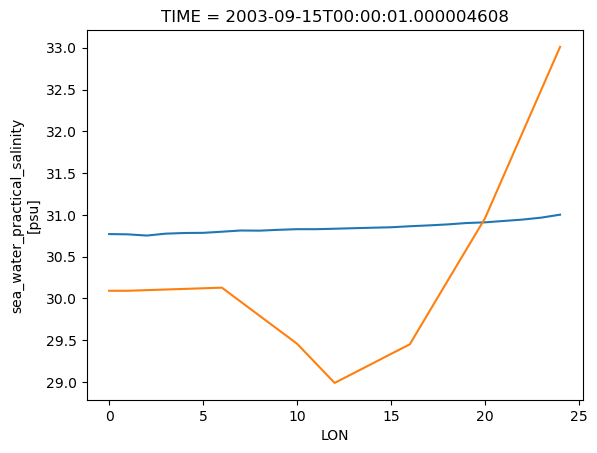

In [21]:
i=0
j=0
tran_cut_time_k = tran_cut.isel(time=i,k=j)
time = [np.array(tran_cut_time_k.time)]
k_num = [RC[j]]

#sampled_transect_temp = griddata(points_nonan, np.array(tran_cut_time_k['SALT']).ravel()[~np.isnan(points[:,0].ravel())], (transect_lon, transect_lat))
sampled_transect_temp = griddata(points, np.array(tran_cut_time_k['SALT'].T).ravel(), (transect_lon, transect_lat))

plt.plot(sampled_transect_temp)
data['PSAL'].isel(TIME=i,Z=0).plot()


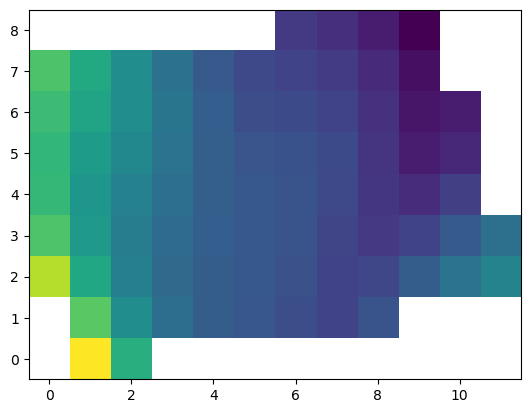

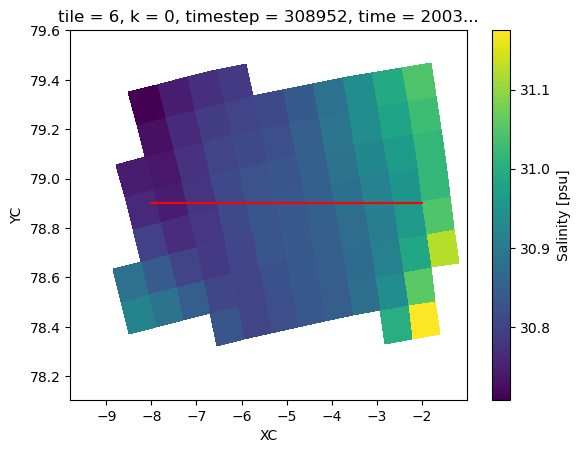

In [22]:
plt.imshow(tran_cut['SALT'].isel(k=0,time=0).T)
plt.gca().invert_yaxis()
plt.show()
tran_cut['SALT'].isel(k=0,time=0).plot(x = 'XC',y='YC')
plt.plot(lon_sampled,lat_sampled,'r')

In [31]:
for i in tqdm(range(0,len(tran_cut.time))):
    for j in range(0,len(tran_cut['k'])):
        tran_cut_time_k = tran_cut.isel(time=i,k=j)
        time = [np.array(tran_cut_time_k.time)]
        k_num = [RC[j]]
        sampled_transect_salt = griddata(points, np.array(tran_cut_time_k['SALT'].T).ravel(), (transect_lon, transect_lat))
        sampled_transect_temp = griddata(points, np.array(tran_cut_time_k['THETA'].T).ravel(), (transect_lon, transect_lat))
        sampled_transect_salt = np.reshape(sampled_transect_salt, (1,1,len(transect_lon)))
        sampled_transect_temp = np.reshape(sampled_transect_temp, (1,1,len(transect_lon)))
        salt_data = xr.DataArray(sampled_transect_salt ,coords=[time,k_num,data.LON],dims=['time','depth','x'],name='SALT')
        temp_data = xr.DataArray(sampled_transect_temp,coords=[time,k_num,data.LON],dims=['time','depth','x'],name='THETA')
        salt_data.to_netcdf(llc270_data+'fram-subsample/SALT_'+str(i).zfill(4)+'_'+str(j).zfill(2)+'.nc')
        temp_data.to_netcdf(llc270_data+'fram-subsample/THETA_'+str(i).zfill(4)+'_'+str(j).zfill(2)+'.nc')

100%|███████████████████████████████████████| 172/172 [1:52:32<00:00, 39.26s/it]


In [10]:
subsamp_270_files, subsamp_270_filepaths = tools.get_data_paths_from_binary(llc270_data,'fram-subsample',file_end='nc')

llc270_sub_data = xr.open_mfdataset(subsamp_270_filepaths)

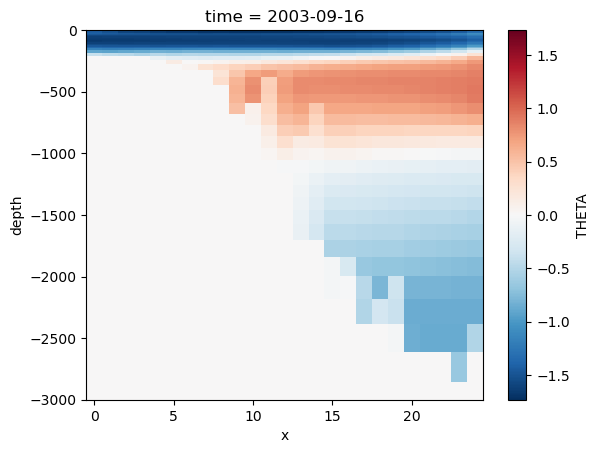

In [11]:
llc270_sub_data.isel(time=0)['THETA'].plot()
plt.ylim(0,-3000)
plt.gca().invert_yaxis()
plt.savefig('./fram_270.png')

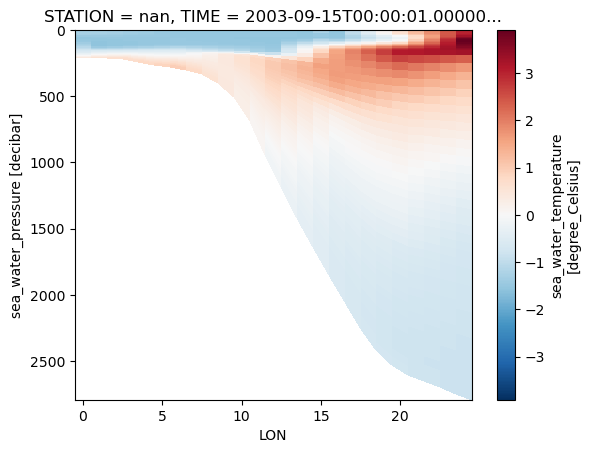

In [12]:
data.isel(STATION=0).sel(TIME=slice('2003-09','2017-12')).set_coords('PRES')['PSAL'].isel(TIME=0).plot(x='LON',y='PRES')
plt.gca().invert_yaxis()
plt.savefig('./fram_obs.png')

In [42]:
np.array(data.isel(STATION=0).sel(TIME=slice('2003-09','2017-12')).set_coords('PRES')['TEMP'].isel(TIME=0).PRES[-1])

array([   5.05554314,   15.16697212,   25.27885807,   35.39120106,
         45.50400114,   55.61725838,   65.73097283,   75.84514457,
         85.95977366,   96.07486015,  106.1904041 ,  116.30640559,
        126.42286467,  136.5397814 ,  146.65715585,  156.77498807,
        220.9073975 ,  285.05821141,  349.22744568,  413.41511617,
        477.62123878,  541.84582944,  606.0889041 ,  670.35047872,
        734.63056929,  798.92919183,  863.24636237,  927.58209698,
        991.93641173, 1056.30932275, 1120.70084615, 1185.11099809,
       1249.53979475, 1313.98725233, 1378.45338705, 1442.93821516,
       1507.44175293, 1571.96401666, 1636.50502266, 1701.06478728,
       1765.64332688, 1830.24065785, 1894.85679661, 1959.49175959,
       2024.14556326, 2088.8182241 , 2153.50975861, 2218.22018334,
       2282.94951484, 2347.6977697 , 2412.46496451, 2477.25111591,
       2542.05624055, 2606.88035512, 2671.72347632, 2736.58562087])

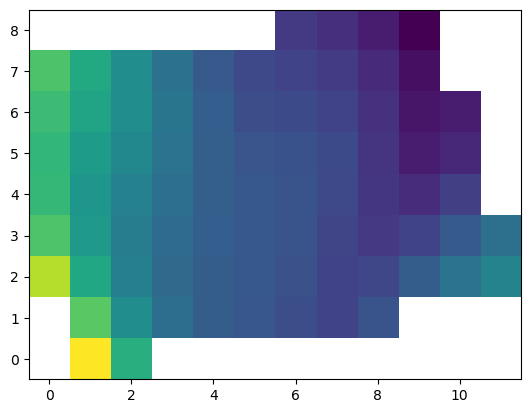

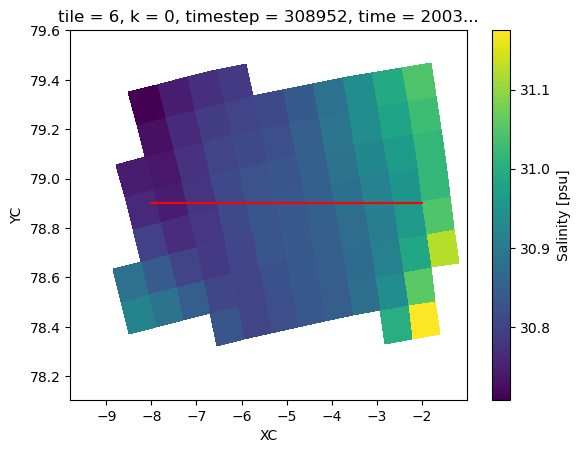

In [23]:
#sampled_transect_salt = griddata(points, np.array(tran_cut_time_k['SALT']).T.ravel(), (transect_lon, transect_lat))
#proj = ccrs.LambertConformal()

#ax = plt.axes(projection=proj)

# #snap['SALT'].plot(x = 'XC',y='YC', transform=ccrs.PlateCarree())
# #new_third_green['SALT'].plot(vmin=32,vmax=34.5, cmap='cmo.haline')
# coast_10m = cfeature.NaturalEarthFeature("physical", "land", "10m", edgecolor="k", facecolor="0.8")

# ax.add_feature(coast_10m)
# gl = ax.gridlines(draw_labels=True)
plt.imshow(tran_cut['SALT'].isel(k=0,time=0).T)
plt.gca().invert_yaxis()
plt.show()
tran_cut['SALT'].isel(k=0,time=0).plot(x = 'XC',y='YC')
plt.plot(lon_sampled,lat_sampled,'r')

In [124]:
salt_temp_270_files, salt_temp_270_filepath = tools.get_data_paths_from_binary(llc270_data,'fram-subsample',file_end='nc')
salt_temp_270 = xr.open_mfdataset(salt_temp_270_filepath)

In [122]:
salt_temp_270.close()

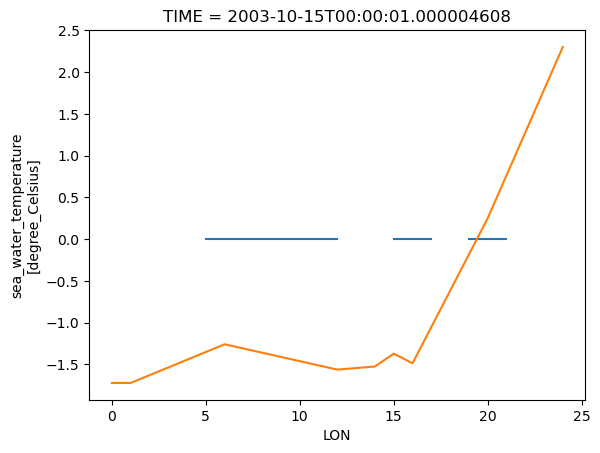

In [126]:
salt_temp_270['THETA'].isel(depth=0,time=1).plot()
data['TEMP'].isel(TIME=1,Z=0).plot()




In [72]:
data

<xarray.Dataset>
Dimensions:    (STATION: 1, TIME: 192, LATITUDE: 25, LONGITUDE: 25, LON: 25,
                Z: 56)
Coordinates:
  * STATION    (STATION) float32 nan
  * TIME       (TIME) datetime64[ns] 2003-09-15T00:00:01.000004608 ... 2019-0...
  * LATITUDE   (LATITUDE) float64 78.9 78.9 78.9 78.9 ... 78.9 78.9 78.9 78.9
  * LONGITUDE  (LONGITUDE) float64 -8.0 -7.75 -7.5 -7.25 ... -2.5 -2.25 -2.0
Dimensions without coordinates: LON, Z
Data variables:
    PSAL       (LON, Z, TIME) float64 dask.array<chunksize=(25, 56, 192), meta=np.ndarray>
    TEMP       (LON, Z, TIME) float64 dask.array<chunksize=(25, 56, 192), meta=np.ndarray>
    PRES       (LON, Z, TIME) float64 dask.array<chunksize=(25, 56, 192), meta=np.ndarray>
    V_VEL      (LON, Z, TIME) float64 dask.array<chunksize=(25, 56, 192), meta=np.ndarray>
Attributes: (12/34)
    platform_code:                 Fram Strait
    site_code:                     1.0
    cruise_ID:                     FS2003 through FS2019
    instrument_type:               AADI RCM 8, 9 or 11, AADI DCM12, AADI RCDP...
    source:                        Norwegian Polar Institute, Norway
    institution:                   Norwegian Polar Institute, Norway
    ...                            ...
    keywords_vocabulary:           GCMD Science Keywords
    keywords:                      EARTH SCIENCE>OCEANS>OCEAN CIRCULATION/OCE...
    iso_topic_category:            oceans
    license:                       Norwegian Polar Institute 
    history:                       Version 1.0
    comment:                       V velocity and S are given as a 3-D matric...

In [43]:
llc1080_path = '/media/basil/Elements/data/N_Greenland/solution_output/'
llc1080_files, llc1080_filepath = tools.get_data_paths_from_binary(llc1080_path,'llc_1080',file_end='nc')
data_1080 = xr.open_mfdataset(llc1080_filepath).set_coords({'longitude','latitude'})

(3835013.457946462, 8583161.108518062)

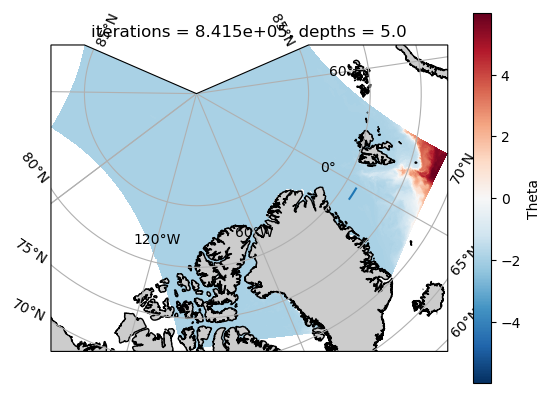

In [44]:
llc1080_data = data_1080.set_coords({'longitude','latitude'})


proj = ccrs.LambertConformal()

ax = plt.axes(projection=proj)

coast_10m = cfeature.NaturalEarthFeature("physical", "land", "10m", edgecolor="k", facecolor="0.8")

ax.add_feature(coast_10m)
gl = ax.gridlines(draw_labels=True)


llc1080_data.isel(iterations=0,depths=0)['Theta'].plot(x='longitude',y='latitude',transform=ccrs.PlateCarree())
#model_gridded['THETA'].isel(k=0,time=0).plot(x='XC',y='YC')
plt.plot(lon_sampled,lat_sampled,transform=ccrs.PlateCarree())
plt.xlim()
plt.ylim()

In [65]:
#np.array(llc1080_data.longitude[0,:,0])
#np.array(model_gridded['XC'][:,0])


In [45]:
transect_lon = np.array(lon_sampled)
transect_lat = np.array(lat_sampled)
lat_cut = llc1080_data.where(np.logical_and(transect_lat.max()+.5>llc1080_data.latitude,transect_lat.min()-.5<llc1080_data.latitude))
lon_cut = lat_cut.where(np.logical_and(transect_lon.max()+.5>lat_cut.longitude,transect_lon.min()-.5<lat_cut.longitude))
tran_cut = lon_cut.dropna(how='all',dim='rows').dropna(how='all',dim='cols')
lon = tran_cut.longitude
lat = tran_cut.latitude
Lon, Lat = lon,lat
#points = np.column_stack([np.ravel(Lon), np.ravel(Lat)])
#sampled_transect_depth_mult = griddata(points, np.array(tran_cut['temperature']).ravel(), (transect_lon, transect_lat))
tran_cut

<xarray.Dataset>
Dimensions:     (iterations: 264, rows: 49, cols: 36, depths: 50)
Coordinates:
  * iterations  (iterations) float32 8.415e+05 8.505e+05 ... 3.138e+06 3.147e+06
    longitude   (iterations, rows, cols) float32 dask.array<chunksize=(1, 49, 36), meta=np.ndarray>
    latitude    (iterations, rows, cols) float32 dask.array<chunksize=(1, 49, 36), meta=np.ndarray>
  * depths      (depths) float32 5.0 15.0 25.0 ... 5.039e+03 5.461e+03 5.906e+03
Dimensions without coordinates: rows, cols
Data variables:
    time        (iterations, rows, cols) float32 dask.array<chunksize=(1, 49, 36), meta=np.ndarray>
    Theta       (iterations, depths, rows, cols) float32 dask.array<chunksize=(1, 50, 49, 36), meta=np.ndarray>
    Salt        (iterations, depths, rows, cols) float32 dask.array<chunksize=(1, 50, 49, 36), meta=np.ndarray>

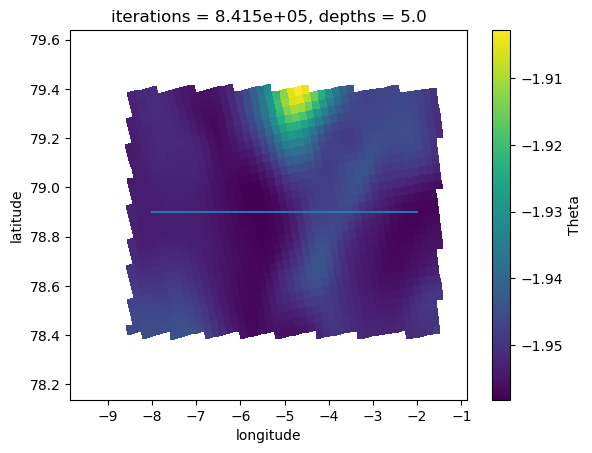

In [46]:
tran_cut['Theta'].isel(iterations=0,depths=0).plot(x='longitude',y='latitude')
plt.plot(transect_lon,transect_lat)

In [55]:
points = np.column_stack([np.ravel(Lon), np.ravel(Lat)])
lon = tran_cut.longitude.isel(iterations=0)
lat = tran_cut.latitude.isel(iterations=0)
Lon, Lat = lon,lat

<xarray.DataArray 'latitude' (rows: 49, cols: 36)>
dask.array<getitem, shape=(49, 36), dtype=float32, chunksize=(49, 36), chunktype=numpy.ndarray>
Coordinates:
    iterations  float32 8.415e+05
    longitude   (rows, cols) float32 dask.array<chunksize=(49, 36), meta=np.ndarray>
    latitude    (rows, cols) float32 dask.array<chunksize=(49, 36), meta=np.ndarray>
Dimensions without coordinates: rows, cols

In [60]:
llc1080_path = '/media/basil/Elements/data/L1_llc1080/fram-subsample/'
points = np.column_stack([np.ravel(Lon), np.ravel(Lat)])
#model_data_subsampled = np.zeros((2,len(tran_cut.time),len(tran_cut['k']),70))
#model_data_subsampled[0,:,:,:] = 'SALT'
#model_data_subsampled[1,:,:,:] = 'THETA'
shape = (50)
# file_path = llc270_data +'grid/RC.data'
# RC = np.fromfile(file_path,'>f4')
# RC = np.reshape(RC, shape)
for i in tqdm(range(0,len(tran_cut.iterations))):
    for j in range(0,len(tran_cut['depths'])):
        tran_cut_time_k = tran_cut.isel(iterations=i,depths=j)
        year = llc1080_files[i].split('.')[1][0:4]
        month = llc1080_files[i].split('.')[1][4:6]
        day = 15
        time = [datetime(int(year),int(month),int(day))]        
        k_num = [np.array(tran_cut['depths'])[j]]
        sampled_transect_salt = griddata(points, np.array(tran_cut_time_k['Salt']).ravel(), (transect_lon, transect_lat))
        sampled_transect_temp = griddata(points, np.array(tran_cut_time_k['Theta']).ravel(), (transect_lon, transect_lat))
        sampled_transect_salt = np.reshape(sampled_transect_salt, (1,1,len(transect_lon)))
        sampled_transect_temp = np.reshape(sampled_transect_temp, (1,1,len(transect_lon)))
        salt_data = xr.DataArray(sampled_transect_salt ,coords=[time,k_num,data.LON],dims=['time','depth','x'],name='Salinity_1080')
        temp_data = xr.DataArray(sampled_transect_temp,coords=[time,k_num,data.LON],dims=['time','depth','x'],name='Temperature_1080')
        salt_data.to_netcdf(llc1080_path+'SALT_'+str(i).zfill(4)+'_'+str(j).zfill(2)+'.nc')
        temp_data.to_netcdf(llc1080_path+'THETA_'+str(i).zfill(4)+'_'+str(j).zfill(2)+'.nc')

100%|███████████████████████████████████████| 264/264 [2:36:17<00:00, 35.52s/it]


In [13]:
llc1080_path = '/media/basil/Elements/data/L1_llc1080/'
llc1080_files, llc1080_filepath = tools.get_data_paths_from_binary(llc1080_path,'fram-subsample',file_end='nc')

In [14]:
llc1080_sub_salt_temp= xr.open_mfdataset(llc1080_filepath)

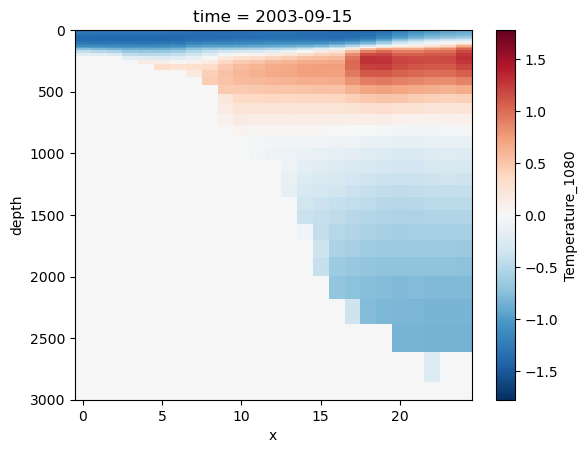

In [15]:
llc1080_sub_salt_temp['Temperature_1080'].sel(time=slice('2003-09','2017-12')).isel(time=0).plot()
plt.ylim(0,3000)
plt.gca().invert_yaxis()
plt.savefig('./fram_1080.png')

In [25]:
i=0
year = llc1080_files[i].split('.')[1][0:4]
month = llc1080_files[i].split('.')[1][4:6]
day = 15
time = [datetime(int(year),int(month),int(day))]
time

[datetime.datetime(2000, 1, 15, 0, 0)]

In [69]:
data.PRES.isel(TIME=0)

<xarray.DataArray 'PRES' (LON: 25, Z: 56)>
dask.array<getitem, shape=(25, 56), dtype=float64, chunksize=(25, 56), chunktype=numpy.ndarray>
Coordinates:
    TIME     datetime64[ns] 2003-09-15T00:00:01.000004608
Dimensions without coordinates: LON, Z
Attributes:
    long_name:        sea_water_pressure
    standard_name:    sea_water_pressure_due_to_sea_water
    units:            decibar
    positive:         down
    reference_scale:  mean_sea_level

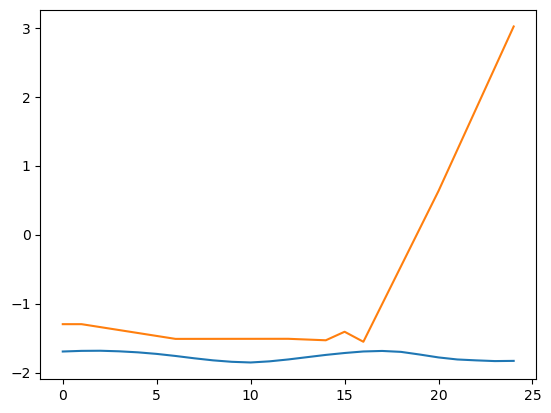

In [35]:
lon = tran_cut.isel(iterations=0).longitude
lat = tran_cut.isel(iterations=0).latitude
Lon, Lat = lon,lat
points = np.column_stack([np.ravel(Lon), np.ravel(Lat)])

sampled_transect_depth_mult = griddata(points, np.array(tran_cut['Theta'].isel(iterations=0,depths=0)).ravel(), (transect_lon, transect_lat))
plt.plot(data.LON,sampled_transect_depth_mult)
plt.plot(data.LON,data['TEMP'].isel(TIME=0,Z=0))

## Converting to one datafile

In [47]:
llc1080_subdata = llc1080_sub_salt_temp.sel(time=slice('2003-09','2017-12'))
llc1080_subdata.coords['depth'] = llc1080_subdata.coords['depth']*-1

In [51]:
llc270_subdata = llc270_sub_data

In [59]:
llc270_subdata.coords['depth'] = llc270_subdata.coords['depth'][::-1]

In [55]:
llc1080_subdata

<xarray.Dataset>
Dimensions:           (time: 172, x: 25, depth: 50)
Coordinates:
  * time              (time) datetime64[ns] 2003-09-15 2003-10-15 ... 2017-12-15
  * x                 (x) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * depth             (depth) float32 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
Data variables:
    Salinity_1080     (time, depth, x) float64 dask.array<chunksize=(1, 1, 25), meta=np.ndarray>
    Temperature_1080  (time, depth, x) float64 dask.array<chunksize=(1, 1, 25), meta=np.ndarray>

In [60]:
data_sub = data.sel(TIME=slice('2003-09','2017-12')).rename({'TIME':'time','LON':'x','Z':'k','TEMP':'Temperature_obs','PSAL':'Salinity_obs','V_VEL':'Velocity_obs'})
data_sub.coords['time'] = llc270_subdata.time

llc270_subdata_correct = llc270_subdata.interp(depth=data_sub['PRES']*-1).rename({'THETA':'Temperature_270','SALT':'Salinity_270'})
llc1080_subdata_correct = llc1080_subdata.interp(depth=data_sub['PRES']*-1)

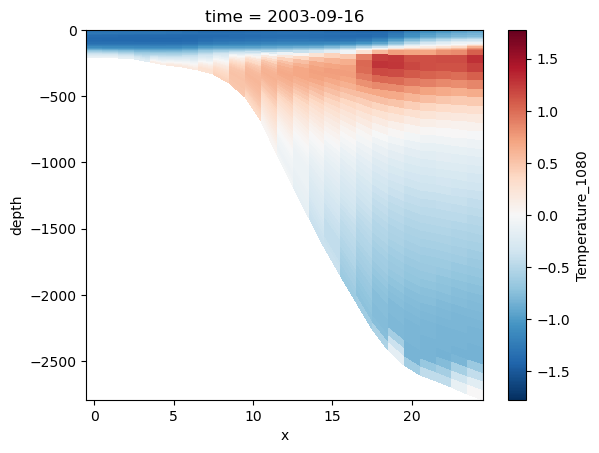

In [71]:
llc1080_subdata_correct['Temperature_1080'].isel(time=0).plot(x='x',y='depth')

In [64]:
model_subsampled_df = xr.merge([llc1080_subdata_correct,llc270_subdata_correct])

In [68]:
data_sub

<xarray.Dataset>
Dimensions:          (STATION: 1, LATITUDE: 25, LONGITUDE: 25, x: 25, k: 56,
                      time: 172)
Coordinates:
  * STATION          (STATION) float32 nan
  * LATITUDE         (LATITUDE) float64 78.9 78.9 78.9 78.9 ... 78.9 78.9 78.9
  * LONGITUDE        (LONGITUDE) float64 -8.0 -7.75 -7.5 ... -2.5 -2.25 -2.0
  * time             (time) datetime64[ns] 2003-09-16 ... 2017-12-16T12:00:00
Dimensions without coordinates: x, k
Data variables:
    Salinity_obs     (x, k, time) float64 dask.array<chunksize=(25, 56, 172), meta=np.ndarray>
    Temperature_obs  (x, k, time) float64 dask.array<chunksize=(25, 56, 172), meta=np.ndarray>
    PRES             (x, k, time) float64 dask.array<chunksize=(25, 56, 172), meta=np.ndarray>
    Velocity_obs     (x, k, time) float64 dask.array<chunksize=(25, 56, 172), meta=np.ndarray>
Attributes: (12/34)
    platform_code:                 Fram Strait
    site_code:                     1.0
    cruise_ID:                     FS2003 through FS2019
    instrument_type:               AADI RCM 8, 9 or 11, AADI DCM12, AADI RCDP...
    source:                        Norwegian Polar Institute, Norway
    institution:                   Norwegian Polar Institute, Norway
    ...                            ...
    keywords_vocabulary:           GCMD Science Keywords
    keywords:                      EARTH SCIENCE>OCEANS>OCEAN CIRCULATION/OCE...
    iso_topic_category:            oceans
    license:                       Norwegian Polar Institute 
    history:                       Version 1.0
    comment:                       V velocity and S are given as a 3-D matric...

In [80]:
sal_obs = data_sub['Salinity_obs']
temp_obs = data_sub['Temperature_obs']
vel_obs = data_sub['Velocity_obs']

full_subsampled_df = xr.merge([model_subsampled_df,sal_obs,temp_obs,vel_obs])
full_subsampled_df.set_coords('depth')

<xarray.Dataset>
Dimensions:           (time: 172, x: 25, k: 56)
Coordinates:
    depth             (x, k, time) float64 dask.array<chunksize=(25, 56, 172), meta=np.ndarray>
  * x                 (x) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time              (time) datetime64[ns] 2003-09-16 ... 2017-12-16T12:00:00
Dimensions without coordinates: k
Data variables:
    Salinity_1080     (time, x, k) float64 dask.array<chunksize=(172, 25, 56), meta=np.ndarray>
    Temperature_1080  (time, x, k) float64 dask.array<chunksize=(172, 25, 56), meta=np.ndarray>
    Salinity_270      (time, x, k) float64 dask.array<chunksize=(172, 25, 56), meta=np.ndarray>
    Temperature_270   (time, x, k) float64 dask.array<chunksize=(172, 25, 56), meta=np.ndarray>
    Salinity_obs      (x, k, time) float64 dask.array<chunksize=(25, 56, 172), meta=np.ndarray>
    Temperature_obs   (x, k, time) float64 dask.array<chunksize=(25, 56, 172), meta=np.ndarray>
    Velocity_obs      (x, k, time) float64 dask.array<chunksize=(25, 56, 172), meta=np.ndarray>

In [97]:
full_subsampled_df.depth.isel(time=0)
full_subsampled_df.x


<xarray.DataArray 'x' (x: 25)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24

In [101]:
diff_temp_1080 = (full_subsampled_df['Temperature_1080']-full_subsampled_df['Temperature_obs']).mean(dim='time').rename('ave_diff_temp_1080')
diff_sal_1080 = (full_subsampled_df['Salinity_1080']-full_subsampled_df['Salinity_obs']).mean(dim='time').rename('ave_diff_sal_1080')
diff_temp_270 = (full_subsampled_df['Temperature_270']-full_subsampled_df['Temperature_obs']).mean(dim='time').rename('ave_diff_temp_270')
diff_sal_270 = (full_subsampled_df['Salinity_270']-full_subsampled_df['Salinity_obs']).mean(dim='time').rename('ave_diff_sal_270')

In [103]:
np.shape(depth)

(25, 56)

In [121]:
x = np.array(full_subsampled_df.x)
k = np.array(full_subsampled_df.k)
diff_sal_270_depth = xr.DataArray(np.array(diff_sal_270),dims=['x','k'],coords=[x,k]).rename('ave_diff_sal_270')
diff_sal_1080_depth = xr.DataArray(np.array(diff_sal_1080),dims=['x','k'],coords=[x,k]).rename('ave_diff_sal_1080')
diff_temp_1080_depth = xr.DataArray(np.array(diff_temp_1080),dims=['x','k'],coords=[x,k]).rename('ave_diff_temp_1080')
diff_temp_270_depth = xr.DataArray(np.array(diff_temp_270),dims=['x','k'],coords=[x,k]).rename('ave_diff_temp_270')

In [122]:
depth = full_subsampled_df['depth'].isel(time=0).rename('depth_1')
depth

<xarray.DataArray 'depth_1' (x: 25, k: 56)>
dask.array<getitem, shape=(25, 56), dtype=float64, chunksize=(25, 56), chunktype=numpy.ndarray>
Coordinates:
    depth    (x, k) float64 dask.array<chunksize=(25, 56), meta=np.ndarray>
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24
    time     datetime64[ns] 2003-09-16
Dimensions without coordinates: k

In [123]:
differences_model_obs = xr.merge([diff_sal_270_depth,diff_sal_1080_depth,diff_temp_1080_depth,diff_temp_270_depth,depth])

In [125]:
full_subsampled_df.to_netcdf(to_hd+'Fram/fram_model_and_obs_subsample.nc')

/tmp/ipykernel_5878/4285439921.py:1: UserWarning: Times can't be serialized faithfully to int64 with requested units 'days since 2003-09-16'. Serializing with units 'hours since 2003-09-16' instead. Set encoding['dtype'] to floating point dtype to serialize with units 'days since 2003-09-16'. Set encoding['units'] to 'hours since 2003-09-16' to silence this warning .
  full_subsampled_df.to_netcdf(to_hd+'Fram/fram_model_and_obs_subsample.nc')


In [127]:
full_data = xr.open_dataset(to_hd+'Fram/fram_model_and_obs_subsample.nc')


<xarray.Dataset>
Dimensions:           (time: 172, x: 25, k: 56)
Coordinates:
    depth             (x, k, time) float64 ...
  * x                 (x) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time              (time) datetime64[ns] 2003-09-16 ... 2017-12-16T12:00:00
Dimensions without coordinates: k
Data variables:
    Salinity_1080     (time, x, k) float64 ...
    Temperature_1080  (time, x, k) float64 ...
    Salinity_270      (time, x, k) float64 ...
    Temperature_270   (time, x, k) float64 ...
    Salinity_obs      (x, k, time) float64 ...
    Temperature_obs   (x, k, time) float64 ...
    Velocity_obs      (x, k, time) float64 ...

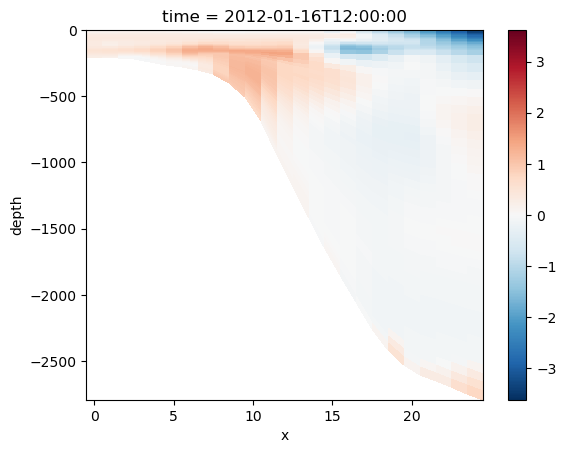

In [132]:
(full_data['Temperature_1080'] - full_data['Temperature_obs']).plot(x='x',y='depth')

In [ ]:
diff_sal_270_depth.plot()

In [86]:
diff_df = xr.merge([full_subsampled_df.isel(time=0)['depth'],diff_temp_1080,diff_sal_1080,diff_temp_270,diff_sal_270])

ValueError: cannot create a Dataset from a DataArray with the same name as one of its coordinates